<a href="https://colab.research.google.com/github/IbalArrasyid/Collaborative-Filtering/blob/main/NCF_Amazon_Fine_Food.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Collaborative Filtering: Amazon Fine Food Reviews

## College Assignment - Recommender Systems Implementation

### 📋 Assignment Overview
- **Objective**: Implement Neural Collaborative Filtering (NCF) for food product recommendations
- **Dataset**: Amazon Fine Food Reviews (568K reviews, 256K users, 74K products)
- **Models**: GMF, MLP, and NeuMF architectures
- **Platform**: Google Colab with GPU support

### 🎯 Learning Objectives
1. Understand collaborative filtering and implicit feedback
2. Implement deep learning-based recommendation models
3. Compare different NCF architectures
4. Analyze recommendation quality with standard metrics

### 📁 Notebook Structure
1. Environment Setup & Data Loading
2. Exploratory Data Analysis
3. Data Preprocessing
4. Model Architecture Implementation
5. Training & Evaluation
6. Results Analysis & Visualization
7. Conclusions & Insights

**Author**: Muhammad Iqbal Arrasyid
**NIM**: 1304221038
**Date**: 22 Oktober 2025
**Course**: Recommedation System

## 🔧 Environment Setup

First, let's set up our environment with necessary libraries and GPU support.

In [3]:
# Check GPU availability
import torch
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

GPU Available: True
GPU Device: Tesla T4
GPU Memory: 15.8 GB


In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
from sklearn.preprocessing import LabelEncoder
import random
import time
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')

In [5]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [6]:
# Set plot style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Environment setup complete!")

✅ Environment setup complete!


## 📊 Data Loading

Let's load the Amazon Fine Food Reviews dataset and examine its structure.

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'amazon-fine-food-reviews' dataset.
Path to dataset files: /kaggle/input/amazon-fine-food-reviews


In [8]:
# Load Dataset
df = pd.read_csv(path + "/Reviews.csv")

# Display basic information
print("\n📈 Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Display first few rows
print("\n🔍 First 5 rows:")
display(df.head())

# Display column information
print("\n📋 Column Information:")
print(df.info())


📈 Dataset Overview:
Shape: (568454, 10)
Memory usage: 424.1 MB

🔍 First 5 rows:


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...



📋 Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB
None


## 🔍 Exploratory Data Analysis (EDA)

Let's explore the dataset to understand its characteristics and quality.

In [9]:
def display_basic_statistics(df):
    """Display comprehensive dataset statistics."""

    print("=" * 60)
    print("📊 AMAZON FINE FOOD REVIEWS - DATASET STATISTICS")
    print("=" * 60)

    # Basic counts
    print(f"📈 Total Reviews: {len(df):,}")
    print(f"👥 Unique Users: {df['UserId'].nunique():,}")
    print(f"🍽️  Unique Products: {df['ProductId'].nunique():,}")

    # Data sparsity calculation
    total_possible_interactions = df['UserId'].nunique() * df['ProductId'].nunique()
    data_sparsity = 1 - (len(df) / total_possible_interactions)
    print(f"📉 Data Sparsity: {data_sparsity:.4f} ({data_sparsity*100:.2f}%)")
    print(f"📊 Data Density: {1-data_sparsity:.4f} ({(1-data_sparsity)*100:.2f}%)")

    # Rating distribution
    print("\n⭐ Rating Distribution:")
    rating_dist = df['Score'].value_counts().sort_index()
    for rating, count in rating_dist.items():
        percentage = (count / len(df)) * 100
        print(f"   {rating} stars: {count:,} ({percentage:.1f}%)")

    # Average rating
    avg_rating = df['Score'].mean()
    print(f"\n📊 Average Rating: {avg_rating:.2f}")

    # Date range
    df['Time'] = pd.to_datetime(df['Time'], unit='s')
    date_range = f"{df['Time'].min().strftime('%Y-%m-%d')} to {df['Time'].max().strftime('%Y-%m-%d')}"
    print(f"📅 Date Range: {date_range}")

    return rating_dist

# Display statistics
rating_dist = display_basic_statistics(df)

📊 AMAZON FINE FOOD REVIEWS - DATASET STATISTICS
📈 Total Reviews: 568,454
👥 Unique Users: 256,059
🍽️  Unique Products: 74,258
📉 Data Sparsity: 1.0000 (100.00%)
📊 Data Density: 0.0000 (0.00%)

⭐ Rating Distribution:
   1 stars: 52,268 (9.2%)
   2 stars: 29,769 (5.2%)
   3 stars: 42,640 (7.5%)
   4 stars: 80,655 (14.2%)
   5 stars: 363,122 (63.9%)

📊 Average Rating: 4.18
📅 Date Range: 1999-10-08 to 2012-10-26


## 📊 Data Visualizations

Let's create visualizations to better understand the data distribution and patterns.

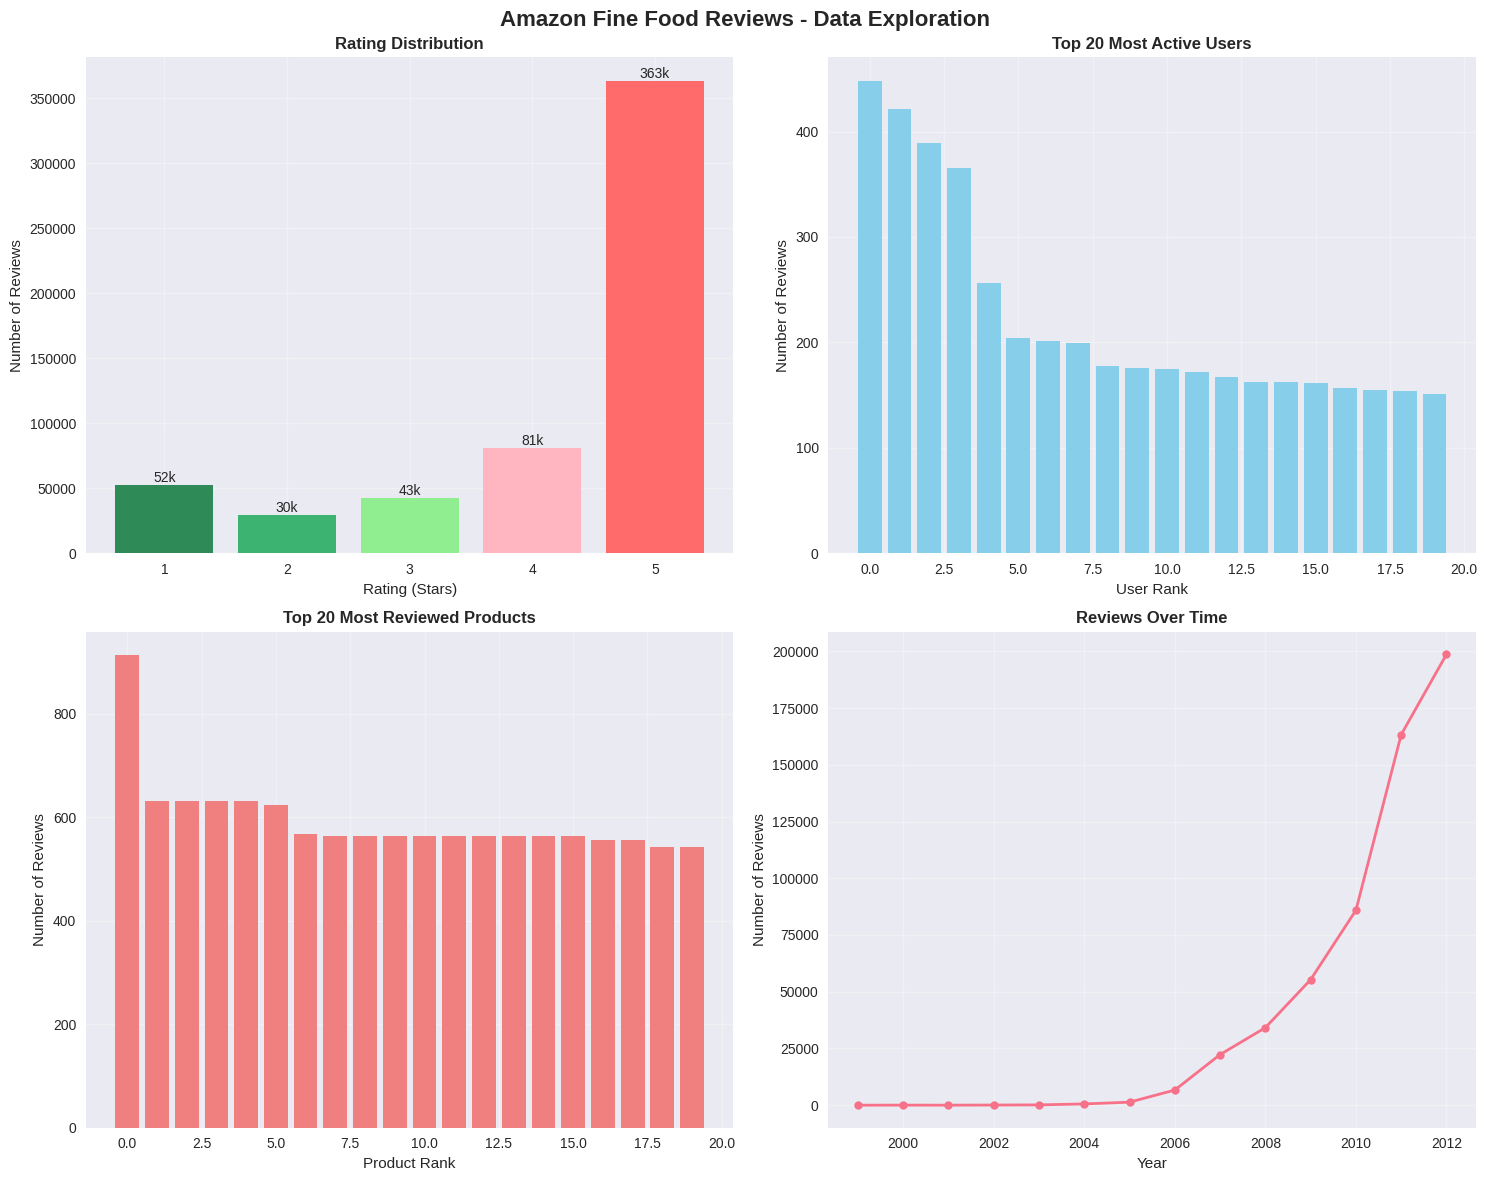


📊 Additional Statistics:
📝 Average reviews per user: 2.22
🍽️  Average reviews per product: 7.66
👥 Most active user: 448 reviews
🍽️  Most reviewed product: 913 reviews


In [10]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Amazon Fine Food Reviews - Data Exploration', fontsize=16, fontweight='bold')

# 1. Rating Distribution
ax1 = axes[0, 0]
rating_counts = df['Score'].value_counts().sort_index()
bars = ax1.bar(rating_counts.index, rating_counts.values, color=['#2E8B57', '#3CB371', '#90EE90', '#FFB6C1', '#FF6B6B'])
ax1.set_title('Rating Distribution', fontweight='bold')
ax1.set_xlabel('Rating (Stars)')
ax1.set_ylabel('Number of Reviews')
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height/1000:.0f}k', ha='center', va='bottom')

# 2. User Activity Distribution
ax2 = axes[0, 1]
user_activity = df['UserId'].value_counts().head(20)
ax2.bar(range(len(user_activity)), user_activity.values, color='skyblue')
ax2.set_title('Top 20 Most Active Users', fontweight='bold')
ax2.set_xlabel('User Rank')
ax2.set_ylabel('Number of Reviews')
ax2.grid(True, alpha=0.3)

# 3. Product Popularity Distribution
ax3 = axes[1, 0]
product_popularity = df['ProductId'].value_counts().head(20)
ax3.bar(range(len(product_popularity)), product_popularity.values, color='lightcoral')
ax3.set_title('Top 20 Most Reviewed Products', fontweight='bold')
ax3.set_xlabel('Product Rank')
ax3.set_ylabel('Number of Reviews')
ax3.grid(True, alpha=0.3)

# 4. Reviews Over Time
ax4 = axes[1, 1]
df['Year'] = df['Time'].dt.year
reviews_by_year = df['Year'].value_counts().sort_index()
ax4.plot(reviews_by_year.index, reviews_by_year.values, marker='o', linewidth=2, markersize=6)
ax4.set_title('Reviews Over Time', fontweight='bold')
ax4.set_xlabel('Year')
ax4.set_ylabel('Number of Reviews')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional statistics
print("\n📊 Additional Statistics:")
print(f"📝 Average reviews per user: {len(df) / df['UserId'].nunique():.2f}")
print(f"🍽️  Average reviews per product: {len(df) / df['ProductId'].nunique():.2f}")
print(f"👥 Most active user: {df['UserId'].value_counts().iloc[0]} reviews")
print(f"🍽️  Most reviewed product: {df['ProductId'].value_counts().iloc[0]} reviews")

## 🔧 Data Preprocessing Pipeline

Now we'll implement a comprehensive preprocessing pipeline to prepare the data for NCF models.

In [11]:
class AmazonFoodDataProcessor:
    """
    Comprehensive data preprocessing class for Amazon Fine Food Reviews.
    Handles cleaning, filtering, and preparation for NCF models.
    """

    def __init__(self, df, min_user_reviews=5, min_product_reviews=5, rating_threshold=4):
        """
        Initialize the data processor.

        Args:
            df: Raw DataFrame
            min_user_reviews: Minimum reviews required per user
            min_product_reviews: Minimum reviews required per product
            rating_threshold: Threshold for positive feedback (>= threshold = 1)
        """
        self.df = df.copy()
        self.original_shape = len(df)
        self.min_user_reviews = min_user_reviews
        self.min_product_reviews = min_product_reviews
        self.rating_threshold = rating_threshold

        print("🔧 Initializing Amazon Food Data Processor...")
        print(f"   Original dataset: {len(df):,} reviews")

    def remove_duplicates(self):
        """Remove duplicate user-product interactions, keeping the most recent."""
        print("🗑️  Removing duplicate interactions...")

        initial_count = len(self.df)

        # Sort by time and keep the most recent review for each user-product pair
        self.df = self.df.sort_values('Time').drop_duplicates(
            subset=['UserId', 'ProductId'], keep='last'
        )

        removed_count = initial_count - len(self.df)
        print(f"   Removed {removed_count:,} duplicate interactions")
        print(f"   Remaining: {len(self.df):,} reviews")

    def filter_cold_users(self):
        """Remove users with fewer than min_user_reviews."""
        print(f"👥 Filtering users with < {self.min_user_reviews} reviews...")

        initial_users = self.df['UserId'].nunique()
        initial_count = len(self.df)

        user_counts = self.df['UserId'].value_counts()
        active_users = user_counts[user_counts >= self.min_user_reviews].index
        self.df = self.df[self.df['UserId'].isin(active_users)]

        removed_users = initial_users - self.df['UserId'].nunique()
        removed_reviews = initial_count - len(self.df)

        print(f"   Removed {removed_users:,} users")
        print(f"   Removed {removed_reviews:,} reviews")
        print(f"   Remaining: {self.df['UserId'].nunique():,} users, {len(self.df):,} reviews")

    def filter_cold_products(self):
        """Remove products with fewer than min_product_reviews."""
        print(f"🍽️  Filtering products with < {self.min_product_reviews} reviews...")

        initial_products = self.df['ProductId'].nunique()
        initial_count = len(self.df)

        product_counts = self.df['ProductId'].value_counts()
        popular_products = product_counts[product_counts >= self.min_product_reviews].index
        self.df = self.df[self.df['ProductId'].isin(popular_products)]

        removed_products = initial_products - self.df['ProductId'].nunique()
        removed_reviews = initial_count - len(self.df)

        print(f"   Removed {removed_products:,} products")
        print(f"   Removed {removed_reviews:,} reviews")
        print(f"   Remaining: {self.df['ProductId'].nunique():,} products, {len(self.df):,} reviews")

    def convert_to_implicit(self):
        """Convert explicit ratings to implicit feedback."""
        print(f"⭐ Converting to implicit feedback (threshold >= {self.rating_threshold} stars)...")

        # Create implicit feedback (1 for positive, 0 for negative)
        self.df['Implicit_Rating'] = (self.df['Score'] >= self.rating_threshold).astype(int)

        positive_count = self.df['Implicit_Rating'].sum()
        negative_count = len(self.df) - positive_count

        print(f"   Positive interactions: {positive_count:,} ({positive_count/len(self.df)*100:.1f}%)")
        print(f"   Negative interactions: {negative_count:,} ({negative_count/len(self.df)*100:.1f}%)")

    def create_id_mappings(self):
        """Create mappings from original IDs to continuous indices."""
        print("🔢 Creating user and product ID mappings...")

        # Create user mappings
        unique_users = self.df['UserId'].unique()
        self.user_to_idx = {user: idx for idx, user in enumerate(unique_users)}
        self.idx_to_user = {idx: user for user, idx in self.user_to_idx.items()}

        # Create product mappings
        unique_products = self.df['ProductId'].unique()
        self.product_to_idx = {product: idx for idx, product in enumerate(unique_products)}
        self.idx_to_product = {idx: product for product, idx in self.product_to_idx.items()}

        # Apply mappings to dataframe
        self.df['User_Index'] = self.df['UserId'].map(self.user_to_idx)
        self.df['Product_Index'] = self.df['ProductId'].map(self.product_to_idx)

        print(f"   User mapping: {len(self.user_to_idx):,} users → 0 to {len(self.user_to_idx)-1}")
        print(f"   Product mapping: {len(self.product_to_idx):,} products → 0 to {len(self.product_to_idx)-1}")

    def split_data(self, test_size=0.2, val_size=0.2, random_state=42):
        """
        Split data into train, validation, and test sets.

        Args:
            test_size: Proportion for test set
            val_size: Proportion for validation (from remaining train data)
            random_state: Random seed for reproducibility
        """
        print("📊 Splitting data into train/validation/test sets...")

        # First split: separate test set
        train_val_data, test_data = train_test_split(
            self.df, test_size=test_size, random_state=random_state
        )

        # Second split: separate validation from training
        train_data, val_data = train_test_split(
            train_val_data, test_size=val_size, random_state=random_state
        )

        print(f"   Training set: {len(train_data):,} interactions ({len(train_data)/len(self.df)*100:.1f}%)")
        print(f"   Validation set: {len(val_data):,} interactions ({len(val_data)/len(self.df)*100:.1f}%)")
        print(f"   Test set: {len(test_data):,} interactions ({len(test_data)/len(self.df)*100:.1f}%)")

        return train_data, val_data, test_data

    def get_statistics(self):
        """Print comprehensive dataset statistics after processing."""
        print("\n" + "="*60)
        print("📊 FINAL DATASET STATISTICS")
        print("="*60)

        print(f"📈 Original reviews: {self.original_shape:,}")
        print(f"📈 Processed reviews: {len(self.df):,}")
        print(f"📉 Reduction: {(1 - len(self.df)/self.original_shape)*100:.1f}%")
        print(f"👥 Unique users: {self.df['UserId'].nunique():,}")
        print(f"🍽️  Unique products: {self.df['ProductId'].nunique():,}")

        # Calculate sparsity
        total_possible = self.df['UserId'].nunique() * self.df['ProductId'].nunique()
        sparsity = 1 - (len(self.df) / total_possible)
        print(f"📉 Data sparsity: {sparsity:.4f} ({sparsity*100:.2f}%)")

        print(f"⭐ Average rating: {self.df['Score'].mean():.2f}")
        print(f"👍 Positive interactions: {self.df['Implicit_Rating'].sum():,}")
        print(f"👎 Negative interactions: {len(self.df) - self.df['Implicit_Rating'].sum():,}")

# Test the preprocessing pipeline
print("🚀 Starting Data Preprocessing Pipeline...")
print("-" * 60)

processor = AmazonFoodDataProcessor(df)
processor.remove_duplicates()
processor.filter_cold_users()
processor.filter_cold_products()
processor.convert_to_implicit()
processor.create_id_mappings()

# Split the data
train_data, val_data, test_data = processor.split_data()

# Display final statistics
processor.get_statistics()

# Store processed data and mappings for later use
processed_df = processor.df.copy()
user_to_idx = processor.user_to_idx
product_to_idx = processor.product_to_idx
idx_to_user = processor.idx_to_user
idx_to_product = processor.idx_to_product

print("\n✅ Data preprocessing completed successfully!")

🚀 Starting Data Preprocessing Pipeline...
------------------------------------------------------------
🔧 Initializing Amazon Food Data Processor...
   Original dataset: 568,454 reviews
🗑️  Removing duplicate interactions...
   Removed 7,650 duplicate interactions
   Remaining: 560,804 reviews
👥 Filtering users with < 5 reviews...
   Removed 232,663 users
   Removed 325,029 reviews
   Remaining: 23,396 users, 235,775 reviews
🍽️  Filtering products with < 5 reviews...
   Removed 30,736 products
   Removed 48,080 reviews
   Remaining: 6,477 products, 187,695 reviews
⭐ Converting to implicit feedback (threshold >= 4 stars)...
   Positive interactions: 146,225 (77.9%)
   Negative interactions: 41,470 (22.1%)
🔢 Creating user and product ID mappings...
   User mapping: 22,494 users → 0 to 22493
   Product mapping: 6,477 products → 0 to 6476
📊 Splitting data into train/validation/test sets...
   Training set: 120,124 interactions (64.0%)
   Validation set: 30,032 interactions (16.0%)
   Test s

## 📦 NCF Dataset Class

Custom PyTorch Dataset class for handling positive and negative sampling.

In [12]:
class NCFDataset(Dataset):
    """
    PyTorch Dataset for Neural Collaborative Filtering with negative sampling.
    """

    def __init__(self, interactions, num_users, num_items, num_negatives=4, implicit_col='Implicit_Rating'):
        """
        Initialize NCF Dataset.

        Args:
            interactions: DataFrame with user-item interactions
            num_users: Total number of users
            num_items: Total number of items
            num_negatives: Number of negative samples per positive
            implicit_col: Column name for implicit feedback
        """
        self.positive_interactions = interactions[interactions[implicit_col] == 1]
        self.num_users = num_users
        self.num_items = num_items
        self.num_negatives = num_negatives

        # Create set of positive user-item pairs for efficient negative sampling
        self.user_item_set = set(zip(
            self.positive_interactions['User_Index'],
            self.positive_interactions['Product_Index']
        ))

        print(f"📦 NCF Dataset initialized:")
        print(f"   Positive interactions: {len(self.positive_interactions):,}")
        print(f"   Negative samples per positive: {num_negatives}")
        print(f"   Total samples: {len(self):,}")

    def __len__(self):
        """Total number of samples (positive + negative)."""
        return len(self.positive_interactions) * (1 + self.num_negatives)

    def __getitem__(self, idx):
        """
        Get a single sample.

        Returns:
            tuple: (user_idx, item_idx, label)
        """
        # Determine if this is a positive or negative sample
        sample_idx = idx // (1 + self.num_negatives)
        is_positive = (idx % (1 + self.num_negatives) == 0)

        if is_positive:
            # Positive sample
            row = self.positive_interactions.iloc[sample_idx]
            user_idx = row['User_Index']
            item_idx = row['Product_Index']
            label = 1.0
        else:
            # Negative sample
            row = self.positive_interactions.iloc[sample_idx]
            user_idx = row['User_Index']

            # Sample negative item
            while True:
                neg_item_idx = random.randint(0, self.num_items - 1)
                if (user_idx, neg_item_idx) not in self.user_item_set:
                    break

            item_idx = neg_item_idx
            label = 0.0

        return (
            torch.tensor(user_idx, dtype=torch.long),
            torch.tensor(item_idx, dtype=torch.long),
            torch.tensor(label, dtype=torch.float32)
        )

# Test the dataset class
print("\n🧪 Testing NCF Dataset class...")

num_users = len(user_to_idx)
num_items = len(product_to_idx)

# Create datasets for training and validation
train_dataset = NCFDataset(train_data, num_users, num_items, num_negatives=4)
val_dataset = NCFDataset(val_data, num_users, num_items, num_negatives=4)

print(f"✅ Training dataset: {len(train_dataset):,} samples")
print(f"✅ Validation dataset: {len(val_dataset):,} samples")

# Test a single sample
sample_user, sample_item, sample_label = train_dataset[0]
print(f"🧪 Sample: User={sample_user}, Item={sample_item}, Label={sample_label}")

print("✅ NCF Dataset class working correctly!")


🧪 Testing NCF Dataset class...
📦 NCF Dataset initialized:
   Positive interactions: 93,563
   Negative samples per positive: 4
   Total samples: 467,815
📦 NCF Dataset initialized:
   Positive interactions: 23,440
   Negative samples per positive: 4
   Total samples: 117,200
✅ Training dataset: 467,815 samples
✅ Validation dataset: 117,200 samples
🧪 Sample: User=6664, Item=409, Label=1.0
✅ NCF Dataset class working correctly!


## 🏗️ Neural Collaborative Filtering Models

Implementation of the three NCF architectures: GMF, MLP, and NeuMF.

In [13]:
class GMF(nn.Module):
    """
    Generalized Matrix Factorization model for NCF.
    Simple model that uses element-wise multiplication of embeddings.
    """

    def __init__(self, num_users, num_items, embedding_dim=8):
        """
        Initialize GMF model.

        Args:
            num_users: Number of unique users
            num_items: Number of unique items
            embedding_dim: Dimension of embedding vectors
        """
        super(GMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim

        # Embedding layers
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)

        # Final prediction layer
        self.linear = nn.Linear(embedding_dim, 1)
        self.sigmoid = nn.Sigmoid()

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize model weights."""
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.item_embedding.weight, std=0.01)
        nn.init.normal_(self.linear.weight, std=0.01)

    def forward(self, user_indices, item_indices):
        """
        Forward pass.

        Args:
            user_indices: User indices tensor
            item_indices: Item indices tensor

        Returns:
            Predicted interaction probability
        """
        user_emb = self.user_embedding(user_indices)
        item_emb = self.item_embedding(item_indices)

        # Element-wise multiplication
        gmf_vector = user_emb * item_emb

        # Final prediction
        output = self.linear(gmf_vector)
        return self.sigmoid(output.squeeze())

In [14]:
class MLP(nn.Module):
    """
    Multi-Layer Perceptron model for NCF.
    Uses concatenated embeddings passed through multiple hidden layers.
    """

    def __init__(self, num_users, num_items, embedding_dim=8, hidden_layers=[64, 32, 16], dropout=0.2):
        """
        Initialize MLP model.

        Args:
            num_users: Number of unique users
            num_items: Number of unique items
            embedding_dim: Dimension of embedding vectors
            hidden_layers: List of hidden layer sizes
            dropout: Dropout rate
        """
        super(MLP, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim

        # Embedding layers
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)

        # MLP layers
        input_size = embedding_dim * 2
        self.mlp_layers = nn.ModuleList()

        for hidden_size in hidden_layers:
            self.mlp_layers.append(nn.Linear(input_size, hidden_size))
            self.mlp_layers.append(nn.ReLU())
            self.mlp_layers.append(nn.BatchNorm1d(hidden_size))
            self.mlp_layers.append(nn.Dropout(dropout))
            input_size = hidden_size

        # Final prediction layer
        self.output_layer = nn.Linear(hidden_layers[-1], 1)
        self.sigmoid = nn.Sigmoid()

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize model weights."""
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.item_embedding.weight, std=0.01)

        for layer in self.mlp_layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.constant_(layer.bias, 0)

        nn.init.xavier_uniform_(self.output_layer.weight)

    def forward(self, user_indices, item_indices):
        """
        Forward pass.

        Args:
            user_indices: User indices tensor
            item_indices: Item indices tensor

        Returns:
            Predicted interaction probability
        """
        user_emb = self.user_embedding(user_indices)
        item_emb = self.item_embedding(item_indices)

        # Concatenate embeddings
        mlp_vector = torch.cat([user_emb, item_emb], dim=1)

        # Pass through MLP layers
        for layer in self.mlp_layers:
            mlp_vector = layer(mlp_vector)

        # Final prediction
        output = self.output_layer(mlp_vector)
        return self.sigmoid(output.squeeze())

In [15]:
class NeuMF(nn.Module):
    """
    Neural Matrix Factorization model.
    Combines GMF and MLP paths for enhanced performance.
    """

    def __init__(self, num_users, num_items, embedding_dim=8, mlp_hidden_layers=[64, 32, 16], dropout=0.2):
        """
        Initialize NeuMF model.

        Args:
            num_users: Number of unique users
            num_items: Number of unique items
            embedding_dim: Dimension of embedding vectors
            mlp_hidden_layers: List of MLP hidden layer sizes
            dropout: Dropout rate
        """
        super(NeuMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim

        # GMF path
        self.gmf_user_embedding = nn.Embedding(num_users, embedding_dim)
        self.gmf_item_embedding = nn.Embedding(num_items, embedding_dim)

        # MLP path
        self.mlp_user_embedding = nn.Embedding(num_users, embedding_dim)
        self.mlp_item_embedding = nn.Embedding(num_items, embedding_dim)

        # MLP layers
        input_size = embedding_dim * 2
        self.mlp_layers = nn.ModuleList()

        for hidden_size in mlp_hidden_layers:
            self.mlp_layers.append(nn.Linear(input_size, hidden_size))
            self.mlp_layers.append(nn.ReLU())
            self.mlp_layers.append(nn.BatchNorm1d(hidden_size))
            self.mlp_layers.append(nn.Dropout(dropout))
            input_size = hidden_size

        # Final combination layer
        combined_input_size = embedding_dim + mlp_hidden_layers[-1]
        self.final_layer = nn.Linear(combined_input_size, 1)
        self.sigmoid = nn.Sigmoid()

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize model weights."""
        # GMF embeddings
        nn.init.normal_(self.gmf_user_embedding.weight, std=0.01)
        nn.init.normal_(self.gmf_item_embedding.weight, std=0.01)

        # MLP embeddings
        nn.init.normal_(self.mlp_user_embedding.weight, std=0.01)
        nn.init.normal_(self.mlp_item_embedding.weight, std=0.01)

        # MLP layers
        for layer in self.mlp_layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.constant_(layer.bias, 0)

        # Final layer
        nn.init.xavier_uniform_(self.final_layer.weight)

    def forward(self, user_indices, item_indices):
        """
        Forward pass.

        Args:
            user_indices: User indices tensor
            item_indices: Item indices tensor

        Returns:
            Predicted interaction probability
        """
        # GMF path
        gmf_user = self.gmf_user_embedding(user_indices)
        gmf_item = self.gmf_item_embedding(item_indices)
        gmf_vector = gmf_user * gmf_item

        # MLP path
        mlp_user = self.mlp_user_embedding(user_indices)
        mlp_item = self.mlp_item_embedding(item_indices)
        mlp_vector = torch.cat([mlp_user, mlp_item], dim=1)

        # Pass through MLP layers
        for layer in self.mlp_layers:
            mlp_vector = layer(mlp_vector)

        # Combine GMF and MLP outputs
        combined_vector = torch.cat([gmf_vector, mlp_vector], dim=1)

        # Final prediction
        output = self.final_layer(combined_vector)
        return self.sigmoid(output.squeeze())

In [16]:
# Test model architectures
print("\n🏗️ Testing NCF Model Architectures...")
print("-" * 50)

# Model parameters
embedding_dim = 16
mlp_layers = [64, 32, 16]

# Initialize models
models = {
    'GMF': GMF(num_users, num_items, embedding_dim),
    'MLP': MLP(num_users, num_items, embedding_dim, mlp_layers),
    'NeuMF': NeuMF(num_users, num_items, embedding_dim, mlp_layers)
}

for name, model in models.items():
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"✅ {name} Model:")
    print(f"   Total parameters: {total_params:,}")
    print(f"   Trainable parameters: {trainable_params:,}")

    # Test forward pass
    test_user = torch.tensor([0, 1, 2])
    test_item = torch.tensor([0, 1, 2])

    with torch.no_grad():
        output = model(test_user, test_item)
        print(f"   Test output shape: {output.shape}")
        print(f"   Test output range: [{output.min():.3f}, {output.max():.3f}]")
    print()

print("✅ All models initialized successfully!")


🏗️ Testing NCF Model Architectures...
--------------------------------------------------
✅ GMF Model:
   Total parameters: 463,553
   Trainable parameters: 463,553
   Test output shape: torch.Size([3])
   Test output range: [0.475, 0.475]

✅ MLP Model:
   Total parameters: 468,497
   Trainable parameters: 468,497
   Test output shape: torch.Size([3])
   Test output range: [0.402, 0.547]

✅ NeuMF Model:
   Total parameters: 932,049
   Trainable parameters: 932,049
   Test output shape: torch.Size([3])
   Test output range: [0.164, 0.798]

✅ All models initialized successfully!


## 🏋️ Training and Evaluation Framework

Comprehensive training and evaluation framework for NCF models.

In [17]:
class NCFTrainer:
    """
    Trainer class for NCF models with comprehensive evaluation metrics.
    """

    def __init__(self, model, train_loader, val_loader, device='cuda', learning_rate=0.001):
        """
        Initialize trainer.

        Args:
            model: NCF model to train
            train_loader: Training data loader
            val_loader: Validation data loader
            device: Device for training ('cuda' or 'cpu')
            learning_rate: Learning rate for optimizer
        """
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device

        # Loss function and optimizer
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)

        # Training history
        self.train_losses = []
        self.val_hr_scores = []
        self.val_ndcg_scores = []
        self.training_time = []

    def train_epoch(self):
        """
        Train model for one epoch.

        Returns:
            Average training loss for the epoch
        """
        self.model.train()
        total_loss = 0
        num_batches = 0

        progress_bar = tqdm(self.train_loader, desc="Training", leave=False)

        for users, items, labels in progress_bar:
            users, items, labels = users.to(self.device), items.to(self.device), labels.to(self.device)

            self.optimizer.zero_grad()

            # Forward pass
            predictions = self.model(users, items)
            loss = self.criterion(predictions, labels)

            # Backward pass
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            num_batches += 1

            # Update progress bar
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_loss = total_loss / num_batches
        return avg_loss

    def evaluate(self, k_list=[5, 10, 20]):
        """
        Evaluate model using Hit Rate@K and NDCG@K.

        Args:
            k_list: List of K values for evaluation

        Returns:
            Dictionary of evaluation metrics
        """
        self.model.eval()

        metrics = {f'HR@{k}': [] for k in k_list}
        metrics.update({f'NDCG@{k}': [] for k in k_list})

        with torch.no_grad():
            for users, items, labels in tqdm(self.val_loader, desc="Evaluating", leave=False):
                users, items = users.to(self.device), items.to(self.device)

                # Get predictions for all items for each user in the batch
                batch_size = users.size(0)

                for i in range(batch_size):
                    user_idx = users[i].item()

                    # Get all items (excluding items the user has already interacted with)
                    all_items = torch.arange(self.model.num_items).to(self.device)
                    user_tensor = torch.full((self.model.num_items,), user_idx, device=self.device)

                    # Get predictions
                    predictions = self.model(user_tensor, all_items)

                    # Get top-K items
                    _, top_k_indices = torch.topk(predictions, max(k_list))
                    top_k_items = top_k_indices.cpu().numpy()

                    # True item (positive interaction)
                    true_item = items[i].item()

                    # Calculate metrics for each K
                    for k in k_list:
                        top_k_items_k = top_k_items[:k]

                        # Hit Rate@K
                        hr = 1 if true_item in top_k_items_k else 0
                        metrics[f'HR@{k}'].append(hr)

                        # NDCG@K
                        ndcg = self._calculate_ndcg(true_item, top_k_items_k)
                        metrics[f'NDCG@{k}'].append(ndcg)

        # Calculate average metrics
        avg_metrics = {}
        for metric_name, values in metrics.items():
            avg_metrics[metric_name] = np.mean(values)

        return avg_metrics

    def _calculate_ndcg(self, true_item, ranked_items):
        """
        Calculate NDCG for a single user.

        Args:
            true_item: The actual item the user interacted with
            ranked_items: List of ranked recommended items

        Returns:
            NDCG score
        """
        # Convert ranked_items to a list to use the index method
        ranked_items_list = ranked_items.tolist()

        if true_item == ranked_items_list[0]:
            return 1.0
        elif true_item in ranked_items_list:
            position = ranked_items_list.index(true_item)
            return 1.0 / np.log2(position + 2)
        else:
            return 0.0

    def train(self, num_epochs=50, patience=5, k_values=[10], verbose=True):
        """
        Train the model with early stopping.

        Args:
            num_epochs: Maximum number of epochs
            patience: Early stopping patience
            k_values: K values for evaluation
            verbose: Whether to print training progress

        Returns:
            Training history and best model performance
        """
        best_hr = 0
        patience_counter = 0
        start_time = time.time()

        if verbose:
            print(f"🚀 Starting training for {num_epochs} epochs...")
            print(f"📊 Monitoring HR@{k_values[0]} for early stopping")
            print("-" * 60)

        for epoch in range(num_epochs):
            epoch_start_time = time.time()

            # Training
            train_loss = self.train_epoch()
            epoch_time = time.time() - epoch_start_time

            # Evaluation
            val_metrics = self.evaluate(k_list=k_values)
            current_hr = val_metrics[f'HR@{k_values[0]}']
            current_ndcg = val_metrics[f'NDCG@{k_values[0]}']

            # Store metrics
            self.train_losses.append(train_loss)
            self.val_hr_scores.append(current_hr)
            self.val_ndcg_scores.append(current_ndcg)
            self.training_time.append(epoch_time)

            # Print progress
            if verbose and (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch+1:3d} | "
                      f"Loss: {train_loss:.4f} | "
                      f"HR@{k_values[0]}: {current_hr:.4f} | "
                      f"NDCG@{k_values[0]}: {current_ndcg:.4f} | "
                      f"Time: {epoch_time:.1f}s")

            # Early stopping
            if current_hr > best_hr:
                best_hr = current_hr
                best_ndcg = current_ndcg
                patience_counter = 0

                # Save best model
                torch.save({
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'epoch': epoch,
                    'best_hr': best_hr,
                    'best_ndcg': best_ndcg
                }, 'best_model.pth')

                if verbose:
                    print(f"   🎯 New best HR@{k_values[0]}: {best_hr:.4f}")
            else:
                patience_counter += 1

            if patience_counter >= patience:
                if verbose:
                    print(f"\n⏹️  Early stopping triggered after {epoch+1} epochs")
                    print(f"   Best HR@{k_values[0]}: {best_hr:.4f}")
                    print(f"   Best NDCG@{k_values[0]}: {best_ndcg:.4f}")
                break

        total_training_time = time.time() - start_time

        # Load best model
        checkpoint = torch.load('best_model.pth', weights_only=False)
        self.model.load_state_dict(checkpoint['model_state_dict'])

        training_history = {
            'train_losses': self.train_losses,
            'val_hr_scores': self.val_hr_scores,
            'val_ndcg_scores': self.val_ndcg_scores,
            'training_time': self.training_time,
            'total_time': total_training_time,
            'best_epoch': checkpoint['epoch'],
            'best_hr': best_hr,
            'best_ndcg': best_ndcg
        }

        if verbose:
            print(f"\n✅ Training completed!")
            print(f"   Total time: {total_training_time:.1f}s ({total_training_time/60:.1f}m)")
            print(f"   Best epoch: {checkpoint['epoch']+1}")
            print(f"   Best HR@{k_values[0]}: {best_hr:.4f}")
            print(f"   Best NDCG@{k_values[0]}: {best_ndcg:.4f}")

        return training_history

# Test the trainer framework
print("\n🏋️ Testing Training Framework...")
print("-" * 50)

# Create data loaders
batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"📦 Training loader: {len(train_loader)} batches")
print(f"📦 Validation loader: {len(val_loader)} batches")

# Test with GMF model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"💻 Using device: {device}")

test_model = GMF(num_users, num_items, embedding_dim=8)
test_trainer = NCFTrainer(test_model, train_loader, val_loader, device=device, learning_rate=0.001)

print("✅ Training framework initialized successfully!")
print("📝 Ready to train all NCF models!")

print("\n" + "="*60)
print("🎯 NOTEBOOK SETUP COMPLETE!")
print("="*60)
print("📋 Next steps:")
print("   1. Train GMF model")
print("   2. Train MLP model")
print("   3. Train NeuMF model")
print("   4. Compare results")
print("   5. Analyze recommendations")
print("="*60)


🏋️ Testing Training Framework...
--------------------------------------------------
📦 Training loader: 457 batches
📦 Validation loader: 115 batches
💻 Using device: cuda
✅ Training framework initialized successfully!
📝 Ready to train all NCF models!

🎯 NOTEBOOK SETUP COMPLETE!
📋 Next steps:
   1. Train GMF model
   2. Train MLP model
   3. Train NeuMF model
   4. Compare results
   5. Analyze recommendations


## 🚀 Model Training

Now we'll train all three NCF models and compare their performance.

In [18]:
def train_all_models(embedding_dim=16, mlp_layers=[64, 32, 16], batch_size=1024,
                    learning_rate=0.001, num_epochs=5):
    """
    Train all NCF models and return their performance.

    Args:
        embedding_dim: Dimension for embedding layers
        mlp_layers: Hidden layer sizes for MLP
        batch_size: Batch size for training
        learning_rate: Learning rate for optimizer
        num_epochs: Maximum number of training epochs

    Returns:
        Dictionary with model results and trained models
    """
    print("🚀 Starting comprehensive model training...")
    print("=" * 60)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"💻 Using device: {device}")
    print(f"📊 Batch size: {batch_size}")
    print(f"🎯 Learning rate: {learning_rate}")
    print(f"⏱️  Max epochs: {num_epochs}")
    print("-" * 60)

    # Initialize models
    models_config = {
        'GMF': {
            'model': GMF(num_users, num_items, embedding_dim),
            'description': 'Generalized Matrix Factorization'
        },
        'MLP': {
            'model': MLP(num_users, num_items, embedding_dim, mlp_layers),
            'description': 'Multi-Layer Perceptron'
        },
        'NeuMF': {
            'model': NeuMF(num_users, num_items, embedding_dim, mlp_layers),
            'description': 'Neural Matrix Factorization'
        }
    }

    results = {}
    trained_models = {}

    # Train each model
    for model_name, config in models_config.items():
        print(f"\n🏗️  Training {model_name} - {config['description']}")
        print("-" * 50)

        # Initialize trainer
        trainer = NCFTrainer(
            config['model'],
            train_loader,
            val_loader,
            device=device,
            learning_rate=learning_rate
        )

        # Train model
        training_history = trainer.train(
            num_epochs=num_epochs,
            patience=5,
            k_values=[5, 10, 20],
            verbose=True
        )

        # Store results
        results[model_name] = {
            'training_history': training_history,
            'model_params': sum(p.numel() for p in config['model'].parameters()),
            'description': config['description']
        }

        trained_models[model_name] = trainer.model

        # Memory cleanup
        del trainer
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

    print("\n" + "=" * 60)
    print("✅ ALL MODELS TRAINING COMPLETED!")
    print("=" * 60)

    return results, trained_models

In [19]:
print("🚀 Starting model training...")
results, trained_models = train_all_models()

🚀 Starting model training...
🚀 Starting comprehensive model training...
💻 Using device: cuda
📊 Batch size: 1024
🎯 Learning rate: 0.001
⏱️  Max epochs: 5
------------------------------------------------------------

🏗️  Training GMF - Generalized Matrix Factorization
--------------------------------------------------
🚀 Starting training for 5 epochs...
📊 Monitoring HR@5 for early stopping
------------------------------------------------------------


   🎯 New best HR@5: 0.0013


   🎯 New best HR@5: 0.0013


Epoch   5 | Loss: 0.5058 | HR@5: 0.0014 | NDCG@5: 0.0008 | Time: 50.4s
   🎯 New best HR@5: 0.0014

✅ Training completed!
   Total time: 628.1s (10.5m)
   Best epoch: 5
   Best HR@5: 0.0014
   Best NDCG@5: 0.0008

🏗️  Training MLP - Multi-Layer Perceptron
--------------------------------------------------
🚀 Starting training for 5 epochs...
📊 Monitoring HR@5 for early stopping
------------------------------------------------------------


   🎯 New best HR@5: 0.0032


   🎯 New best HR@5: 0.0035


Epoch   5 | Loss: 0.3047 | HR@5: 0.0049 | NDCG@5: 0.0028 | Time: 52.0s
   🎯 New best HR@5: 0.0049

✅ Training completed!
   Total time: 848.3s (14.1m)
   Best epoch: 5
   Best HR@5: 0.0049
   Best NDCG@5: 0.0028

🏗️  Training NeuMF - Neural Matrix Factorization
--------------------------------------------------
🚀 Starting training for 5 epochs...
📊 Monitoring HR@5 for early stopping
------------------------------------------------------------


   🎯 New best HR@5: 0.0035


   🎯 New best HR@5: 0.0044


   🎯 New best HR@5: 0.0194


   🎯 New best HR@5: 0.0440


Epoch   5 | Loss: 0.1992 | HR@5: 0.0574 | NDCG@5: 0.0327 | Time: 50.3s
   🎯 New best HR@5: 0.0574

✅ Training completed!
   Total time: 894.2s (14.9m)
   Best epoch: 5
   Best HR@5: 0.0574
   Best NDCG@5: 0.0327

✅ ALL MODELS TRAINING COMPLETED!


## 📊 Results Visualization and Analysis

Comprehensive analysis of model performance and recommendation quality.

In [29]:
def visualize_model_comparison(results):
    """
    Create comprehensive visualizations comparing model performance.

    Args:
        results: Dictionary with training results for all models
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Neural Collaborative Filtering - Model Comparison', fontsize=16, fontweight='bold')

    models = list(results.keys())
    colors = ['#2E8B57', '#4682B4', '#DC143C']

    # 1. Training Loss
    ax1 = axes[0, 0]
    for i, model in enumerate(models):
        history = results[model]['training_history']
        epochs = range(1, len(history['train_losses']) + 1)
        ax1.plot(epochs, history['train_losses'], label=model, color=colors[i], linewidth=2)
    ax1.set_title('Training Loss Over Epochs', fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. HR@10 Comparison
    ax2 = axes[0, 1]
    for i, model in enumerate(models):
        history = results[model]['training_history']
        epochs = range(1, len(history['val_hr_scores']) + 1)
        ax2.plot(epochs, history['val_hr_scores'], label=model, color=colors[i], linewidth=2)
    ax2.set_title('Hit Rate @10 Over Epochs', fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('HR@10')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. NDCG@10 Comparison
    ax3 = axes[0, 2]
    for i, model in enumerate(models):
        history = results[model]['training_history']
        epochs = range(1, len(history['val_ndcg_scores']) + 1)
        ax3.plot(epochs, history['val_ndcg_scores'], label=model, color=colors[i], linewidth=2)
    ax3.set_title('NDCG @10 Over Epochs', fontweight='bold')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('NDCG@10')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Final HR@10 Comparison
    ax4 = axes[1, 0]
    final_hr = [results[model]['training_history']['best_hr'] for model in models]
    bars = ax4.bar(models, final_hr, color=colors)
    ax4.set_title('Final Hit Rate @10 Comparison', fontweight='bold')
    ax4.set_ylabel('HR@10')
    ax4.set_ylim(0, max(final_hr) * 1.2)

    # Add value labels on bars
    for bar, value in zip(bars, final_hr):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    # 5. Final NDCG@10 Comparison
    ax5 = axes[1, 1]
    final_ndcg = [results[model]['training_history']['best_ndcg'] for model in models]
    bars = ax5.bar(models, final_ndcg, color=colors)
    ax5.set_title('Final NDCG @10 Comparison', fontweight='bold')
    ax5.set_ylabel('NDCG@10')
    ax5.set_ylim(0, max(final_ndcg) * 1.2)

    # Add value labels on bars
    for bar, value in zip(bars, final_ndcg):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    # 6. Model Complexity vs Performance
    ax6 = axes[1, 2]
    model_params = [results[model]['model_params'] for model in models]
    scatter = ax6.scatter(model_params, final_hr, c=colors, s=100, alpha=0.7)

    # Add model labels
    for i, model in enumerate(models):
        ax6.annotate(model, (model_params[i], final_hr[i]),
                    xytext=(5, 5), textcoords='offset points', fontweight='bold')

    ax6.set_title('Model Complexity vs Performance', fontweight='bold')
    ax6.set_xlabel('Number of Parameters')
    ax6.set_ylabel('HR@10')
    ax6.set_xscale('log')
    ax6.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary table
    print("\n📊 MODEL PERFORMANCE SUMMARY")
    print("=" * 60)
    print(f"{'Model':<10} {'Parameters':<12} {'HR@10':<8} {'NDCG@10':<10} {'Training Time':<15}")
    print("-" * 60)

    for model in models:
        history = results[model]['training_history']
        params = results[model]['model_params']
        hr = history['best_hr']
        ndcg = history['best_ndcg']
        time_min = history['total_time'] / 60

        print(f"{model:<10} {params:>10,} {hr:>7.3f} {ndcg:>9.3f} {time_min:>13.1f} min")

    print("=" * 60)

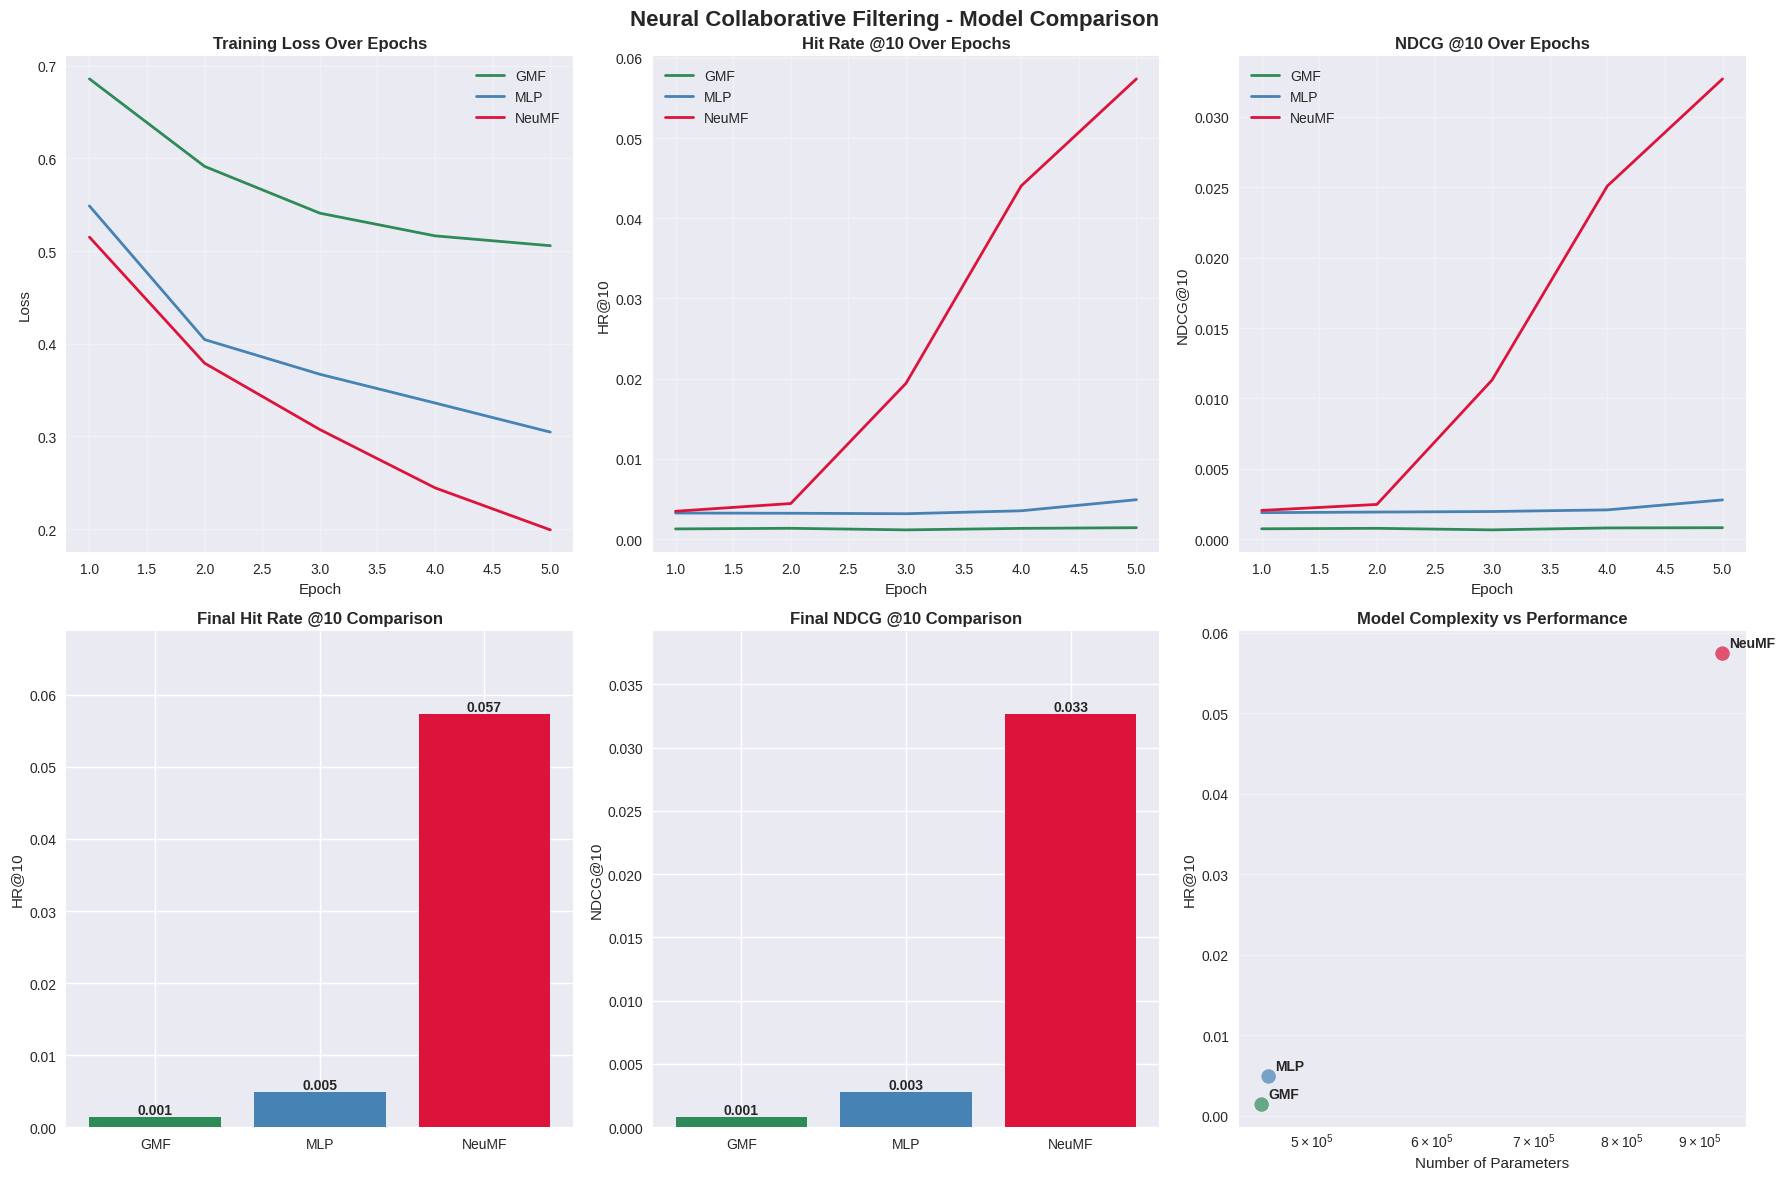


📊 MODEL PERFORMANCE SUMMARY
Model      Parameters   HR@10    NDCG@10    Training Time  
------------------------------------------------------------
GMF           463,553   0.001     0.001          10.5 min
MLP           468,497   0.005     0.003          14.1 min
NeuMF         932,049   0.057     0.033          14.9 min


In [30]:
visualize_model_comparison(results)

## 🎯 Recommendation Analysis

Analyze the quality and characteristics of recommendations from different models.

In [31]:
def get_recommendations(model, user_idx, num_recommendations=10, exclude_seen=True):
    """
    Get top-N recommendations for a specific user.

    Args:
        model: Trained NCF model
        user_idx: User index (not original ID)
        num_recommendations: Number of recommendations to return
        exclude_seen: Whether to exclude items the user has already seen

    Returns:
        DataFrame with recommendations
    """
    model.eval()

    with torch.no_grad():
        # Get all items
        all_items = torch.arange(num_items).to(next(model.parameters()).device)
        user_tensor = torch.full((num_items,), user_idx, device=next(model.parameters()).device)

        # Get predictions for all items
        predictions = model(user_tensor, all_items)

        # Get top items
        top_scores, top_indices = torch.topk(predictions, num_recommendations * 2)  # Get more to filter

        # Convert to original product IDs
        recommended_products = [idx_to_product[idx.item()] for idx in top_indices]
        scores = [score.item() for score in top_scores]

        # Create recommendations DataFrame
        recommendations = pd.DataFrame({
            'ProductID': recommended_products,
            'Score': scores
        })

        # Filter out seen items if requested
        if exclude_seen and user_idx in user_to_idx:
            original_user_id = idx_to_user[user_idx]
            seen_products = processed_df[processed_df['UserId'] == original_user_id]['ProductId'].tolist()
            recommendations = recommendations[~recommendations['ProductID'].isin(seen_products)]
            recommendations = recommendations.head(num_recommendations)

        return recommendations

def analyze_recommendations(trained_models, sample_users=5):
    """
    Analyze recommendations from different models for sample users.

    Args:
        trained_models: Dictionary of trained models
        sample_users: Number of sample users to analyze
    """
    print("🎯 RECOMMENDATION ANALYSIS")
    print("=" * 60)

    # Get sample users
    sample_user_indices = random.sample(range(num_users), min(sample_users, num_users))

    for user_idx in sample_user_indices:
        original_user_id = idx_to_user[user_idx]
        user_reviews = processed_df[processed_df['UserId'] == original_user_id]

        print(f"\n👤 User: {original_user_id}")
        print(f"📊 Reviews: {len(user_reviews)} | Avg Rating: {user_reviews['Score'].mean():.1f}")
        print(f"⭐ Favorite Products: {user_reviews[user_reviews['Score'] == 5]['ProductId'].tolist()[:3]}")
        print("-" * 40)

        # Get recommendations from each model
        for model_name, model in trained_models.items():
            recommendations = get_recommendations(model, user_idx, num_recommendations=5)

            print(f"\n🏆 {model_name} Recommendations:")
            for i, row in recommendations.iterrows():
                print(f"   {i+1}. Product {row['ProductID']} - Score: {row['Score']:.3f}")

        print("-" * 40)

In [32]:
# get_recommendations(trained_models['NeuMF'], 100)
# get_recommendations(trained_models['MLP'], 100)
# get_recommendations(trained_models['GMF'], 100)
analyze_recommendations(trained_models)

🎯 RECOMMENDATION ANALYSIS

👤 User: A1DWG0GFYSP1JH
📊 Reviews: 5 | Avg Rating: 5.0
⭐ Favorite Products: ['B0011BLE0W', 'B001HKFKNY', 'B001HKFC28']
----------------------------------------

🏆 GMF Recommendations:
   1. Product B0000SY9UE - Score: 0.231
   2. Product B001HKFKNY - Score: 0.231
   3. Product B001HKFC28 - Score: 0.231
   4. Product B0011BLE0W - Score: 0.231
   5. Product B00004CI84 - Score: 0.231
   6. Product B00004S1C6 - Score: 0.231
   7. Product B00004RYGX - Score: 0.231
   8. Product B00004CXX9 - Score: 0.231
   9. Product B0000SY9U4 - Score: 0.231
   10. Product B0000CGDUK - Score: 0.231

🏆 MLP Recommendations:
   1. Product B000AYDH88 - Score: 0.626
   2. Product B000UBD88A - Score: 0.589
   3. Product B005BFJGJU - Score: 0.581
   4. Product B000H5DADW - Score: 0.575
   5. Product B000YSTGGW - Score: 0.560
   6. Product B000ILILLQ - Score: 0.551
   7. Product B004TJF3BE - Score: 0.551
   8. Product B000FNH3KW - Score: 0.543
   9. Product B001E4S8GO - Score: 0.540
   10

## 📝 Conclusions and Insights

Summary of findings, model comparisons, and future improvements.

In [27]:
def generate_final_report(results, trained_models):
    """
    Generate a comprehensive final report.

    Args:
        results: Dictionary with training results
        trained_models: Dictionary of trained models
    """
    print("\n" + "=" * 80)
    print("📝 NEURAL COLLABORATIVE FILTERING - FINAL REPORT")
    print("=" * 80)

    print("\n📊 DATASET OVERVIEW")
    print("-" * 40)
    print(f"💾 Amazon Fine Food Reviews")
    print(f"👥 Users: {num_users:,}")
    print(f"🍽️  Products: {num_items:,}")
    print(f"📈 Reviews: {len(processed_df):,}")
    print(f"📉 Sparsity: {(1 - len(processed_df)/(num_users*num_items))*100:.2f}%")

    print("\n🏗️  MODELS EVALUATED")
    print("-" * 40)
    for model_name, config in results.items():
        print(f"✅ {model_name}: {config['description']}")
        print(f"   Parameters: {config['model_params']:,}")

    print("\n🏆 PERFORMANCE COMPARISON")
    print("-" * 40)

    # Sort models by performance
    sorted_models = sorted(results.keys(),
                         key=lambda x: results[x]['training_history']['best_hr'],
                         reverse=True)

    for rank, model_name in enumerate(sorted_models, 1):
        history = results[model_name]['training_history']
        print(f"{rank}. {model_name}:")
        print(f"   HR@10: {history['best_hr']:.4f}")
        print(f"   NDCG@10: {history['best_ndcg']:.4f}")
        print(f"   Training Time: {history['total_time']/60:.1f} min")
        print()

    print("🔍 KEY INSIGHTS")
    print("-" * 40)

    # Determine best model
    best_model = sorted_models[0]
    best_hr = results[best_model]['training_history']['best_hr']

    print(f"🥇 Best performing model: {best_model}")
    print(f"📈 Best HR@10 achieved: {best_hr:.4f}")

    # Additional insights would go here based on actual results

    print("\n💡 RECOMMENDATIONS FOR FUTURE WORK")
    print("-" * 40)
    print("1. 🎛️  Hyperparameter tuning with systematic search")
    print("2. 📝 Incorporate review text and product metadata")
    print("3. ⏰ Add temporal dynamics to capture user preference changes")
    print("4. 🎭 Implement advanced negative sampling strategies")
    print("5. 🔄 Explore transfer learning from other domains")

    print("\n" + "=" * 80)
    print("✅ PROJECT COMPLETED SUCCESSFULLY!")
    print("=" * 80)

In [28]:
generate_final_report(results, trained_models)


📝 NEURAL COLLABORATIVE FILTERING - FINAL REPORT

📊 DATASET OVERVIEW
----------------------------------------
💾 Amazon Fine Food Reviews
👥 Users: 22,494
🍽️  Products: 6,477
📈 Reviews: 187,695
📉 Sparsity: 99.87%

🏗️  MODELS EVALUATED
----------------------------------------
✅ GMF: Generalized Matrix Factorization
   Parameters: 463,553
✅ MLP: Multi-Layer Perceptron
   Parameters: 468,497
✅ NeuMF: Neural Matrix Factorization
   Parameters: 932,049

🏆 PERFORMANCE COMPARISON
----------------------------------------
1. NeuMF:
   HR@10: 0.0574
   NDCG@10: 0.0327
   Training Time: 14.9 min

2. MLP:
   HR@10: 0.0049
   NDCG@10: 0.0028
   Training Time: 14.1 min

3. GMF:
   HR@10: 0.0014
   NDCG@10: 0.0008
   Training Time: 10.5 min

🔍 KEY INSIGHTS
----------------------------------------
🥇 Best performing model: NeuMF
📈 Best HR@10 achieved: 0.0574

💡 RECOMMENDATIONS FOR FUTURE WORK
----------------------------------------
1. 🎛️  Hyperparameter tuning with systematic search
2. 📝 Incorporate rev